<a href="https://colab.research.google.com/github/Frodo-Swaggins/COMP702PROJECT/blob/main/comp703project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

START OF PREPROCESSING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports and creating the path to the images
import os
import cv2
cv2.__version__
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

mypath = '/content/drive/MyDrive/RandNotes'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

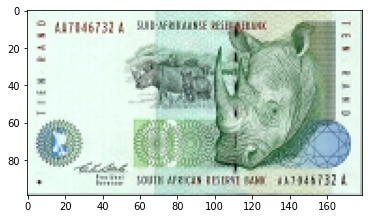

In [ ]:
#Opening the images and loading them as image objects into an array using open cv
images = []
count = 0

for fil in onlyfiles:
  imagepath = '/content/drive/MyDrive/RandNotes/' + fil
  image = cv2.imread(imagepath)
  images.append(image)

plt.imshow(images[0])

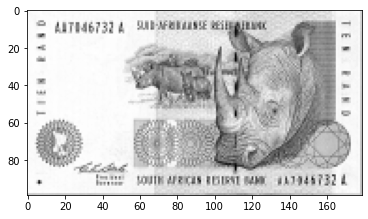

In [ ]:
#grayscale conversion on the array of images
grays = []
for image in images:
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grays.append(gray)
plt.imshow(grays[0], cmap = 'gray')

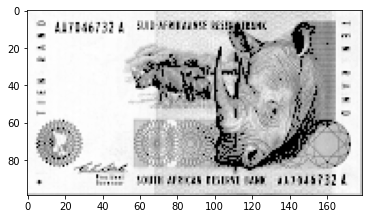

In [ ]:
#Thresholding of the array of images
binary = []
for gray in grays:
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)
  ret, thresh1 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
  ret, thresh2 = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  ret, thresh3 = cv2.threshold(gray, 120, 255, cv2.THRESH_TRUNC)
  ret, thresh4 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO)
  ret, thresh5 = cv2.threshold(gray, 120, 255, cv2.THRESH_TOZERO_INV)
  ret, thresh6 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  adaptiveThresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
 
  binary.append(thresh4)
plt.imshow(binary[0], cmap = 'gray')

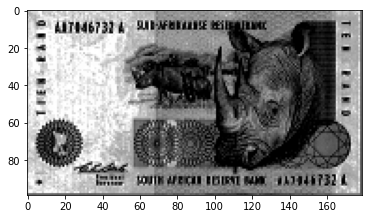

In [ ]:
#Histogram normalisation of the therholded array of images
equ = []

for bin in binary:
  equalised = cv2.equalizeHist(bin)
  equ.append(equalised)

plt.imshow(equ[0], cmap = 'gray')

100


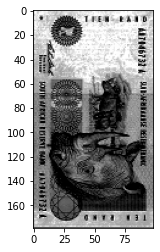

In [ ]:
#Data augmentation is performed on the equalised images
#We take the first half (0-25) of the images and rotate them 90 degrees clockwise
#We take the second half (26-49) of the images and rotate them 90 degrees counterclockwise
#We do this to increase the size of our dataset
preprocessed = []
for i in range (len(equ)):
  if(i<=25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_CLOCKWISE))
  if(i<=49 and i>25):
    preprocessed.append(equ[i])
    preprocessed.append(cv2.rotate(equ[i],cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.imshow(preprocessed[1], cmap = 'gray')
print(len(preprocessed))

END OF PREPROCESSING

In [ ]:
#Enhancement code